In [2]:
import mne
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report
from mne_bids.path import get_bids_path_from_fname
from ecog_preproc_utils import transformData
#!pip install ipympl
#!pip install mne_bids
#%matplotlib qt
#%matplotlib tk

In [3]:
# Change these variables to work for your block
subj = '06'
sess = 'iemu'
task = 'film'
acq = 'clinical'
run = 1

In [4]:
# Change the data directory below to where your data are located. 
data_dir = f'/home/jovyan/shared/ds003688/sub-{subj}/ses-{sess}/ieeg/'
channel_path = f'{data_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_channels.tsv'
raw_path = f'{data_dir}/sub-{subj}_ses-{sess}_task-{task}_acq-{acq}_run-{run}_ieeg.vhdr'

bids_path = get_bids_path_from_fname(raw_path)
base_name = os.path.basename(raw_path).split('.')[0]

In [5]:
# Read data and extract parameters from BIDS files
raw = read_raw_bids(bids_path, verbose=True)

Extracting parameters from /home/jovyan/shared/ds003688/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Reading events from /home/jovyan/shared/ds003688/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_task-film_run-1_events.tsv.
Reading channel info from /home/jovyan/shared/ds003688/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_task-film_acq-clinical_run-1_channels.tsv.
Reading electrode coords from /home/jovyan/shared/ds003688/sub-06/ses-iemu/ieeg/sub-06_ses-iemu_acq-clinical_electrodes.tsv.


/tmp/ipykernel_312/531307012.py:2: RuntimeWarning: The unit for channel(s) MKR1+, MKR2+ has changed from V to NA.
  raw = read_raw_bids(bids_path, verbose=True)


In [6]:
# Read the data assuming we didn't have the BIDS structure in place
raw_nobids = mne.io.read_raw_brainvision(raw_path, preload=True)

Extracting parameters from /home/jovyan/shared/ds003688/sub-06/ses-iemu/ieeg//sub-06_ses-iemu_task-film_acq-clinical_run-1_ieeg.vhdr...
Setting channel info structure...
Reading 0 ... 203145  =      0.000 ...   396.768 secs...


In [7]:
raw.load_data()
raw.info

Reading 0 ... 203145  =      0.000 ...   396.768 secs...


<Info | 11 non-empty values
 bads: 3 items (P48, MKR1+, T03)
 ch_names: P01, P02, P03, P04, P05, P06, P07, P08, P09, P10, P11, P12, P13, ...
 chs: 104 ECoG, 2 Stimulus, 1 ECG, 3 misc, 2 EMG
 custom_ref_applied: False
 dig: 104 items (104 EEG)
 highpass: 0.0 Hz
 line_freq: 50.0
 lowpass: 256.0 Hz
 meas_date: 1900-01-01 00:00:00 UTC
 nchan: 112
 projs: []
 sfreq: 512.0 Hz
 subject_info: 10 items (dict)
>

In [8]:
raw.info['chs'][0]

{'ch_name': 'P01',
 'coil_type': 1 (FIFFV_COIL_EEG),
 'kind': 902 (FIFFV_ECOG_CH),
 'logno': 1,
 'scanno': 1,
 'cal': 1.0,
 'range': 1e-06,
 'loc': array([-0.049895, -0.063538,  0.034958,  0.      ,  0.      ,  0.      ,
              nan,       nan,       nan,       nan,       nan,       nan]),
 'unit': 107 (FIFF_UNIT_V),
 'unit_mul': 0 (FIFF_UNITM_NONE),
 'coord_frame': 4 (FIFFV_COORD_HEAD)}

In [9]:
# covert to pd df 
coord_names=pd.DataFrame(columns=['Channel_Name','x_coord','y_coord','z_coord',
                                  'coil_type','kind','logno','scanno','cal','range','unit','unit_mul', 'coord_frame'])
for i in range(len(raw.info['ch_names'])):                                  # Append rows within for loop
    coord_names.loc[len(coord_names)] =[ raw.info['chs'][i]['ch_name'] , raw.info['chs'][i]['loc'][0],raw.info['chs'][i]['loc'][1],raw.info['chs'][i]['loc'][2],
                                       raw.info['chs'][i]['coil_type'],raw.info['chs'][i]['kind'], raw.info['chs'][i]['logno'],raw.info['chs'][i]['scanno'],
                                       raw.info['chs'][i]['cal'], raw.info['chs'][i]['range'], raw.info['chs'][i]['unit'], raw.info['chs'][i]['unit_mul'], raw.info['chs'][i]['coord_frame'] ]

display(coord_names)   
coord_names.to_csv('/home/jovyan/nh2022-curriculum/hamilton-ieeg-preprocessing/coord_data.csv')  


,Channel_Name,x_coord,y_coord,z_coord,coil_type,kind,logno,scanno,cal,range,unit,unit_mul,coord_frame
0,P01,-0.049895,-0.063538,0.034958,1,902,1,1,1.0,0.000001,107,0,4
1,P02,-0.055895,-0.054538,0.032958,1,902,2,2,1.0,0.000001,107,0,4
2,P03,-0.059895,-0.047538,0.029958,1,902,3,3,1.0,0.000001,107,0,4
3,P04,-0.063895,-0.038538,0.025958,1,902,4,4,1.0,0.000001,107,0,4
4,P05,-0.067895,-0.029538,0.021958,1,902,5,5,1.0,0.000001,107,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,F15,-0.054895,0.027462,0.051958,1,902,108,108,1.0,0.000001,107,0,4
108,F16,-0.056895,0.019462,0.055958,1,902,109,109,1.0,0.000001,107,0,4
109,thor+,NaN,NaN,NaN,0,302,110,110,1.0,0.000001,107,0,4
110,abdo+,NaN,NaN,NaN,0,302,111,111,1.0,0.000001,107,0,4


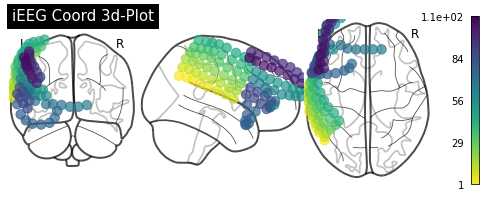

In [49]:
#plot cooords on glass brain 
from nilearn import plotting
node_strength=np.arange(1, 113, 1, dtype=int)
# rng = np.random.default_rng(seed=42)
# node_strength = rng.random((1, 112))
coords = np.vstack((coord_names.x_coord,coord_names.y_coord,coord_names.z_coord)).T

# print(100*coords)
plotting.plot_markers(
    node_strength,
    1000*coords,
    title='iEEG Coord 3d-Plot',
    # output_file='iEEG Coord 3d-Plot.png',

    )


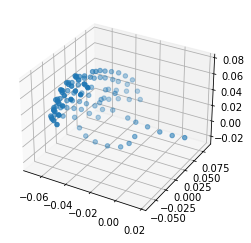

In [50]:
#ploting a matplot
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coord_names.x_coord,coord_names.y_coord,coord_names.z_coord) # plot the point (2,3,4) on the figure
plt.show() 